In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/tmp/ipykernel_4264/2426236682.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./dataset/spotify_data.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1920


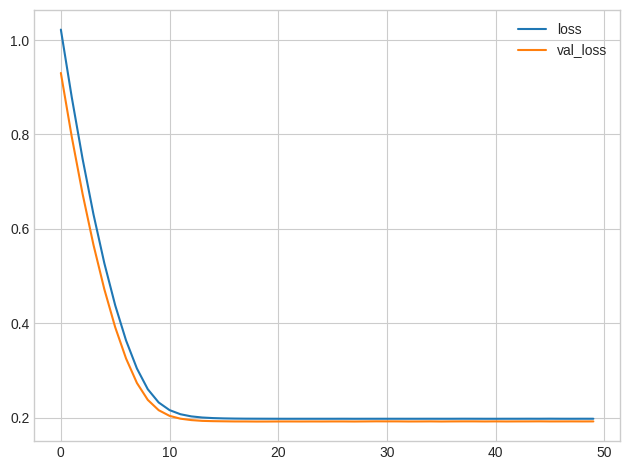

In [5]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1920


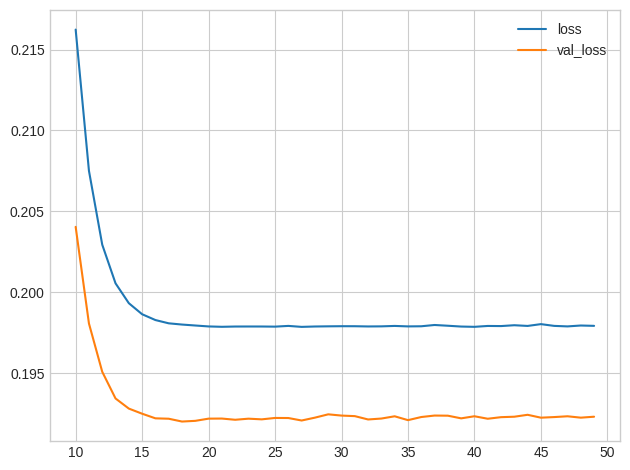

In [8]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 9ms/step - loss: 0.2520 - val_loss: 0.2037
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.2040 - val_loss: 0.1965
Epoch 3/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1985 - val_loss: 0.1954
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1959 - val_loss: 0.1933
Epoch 5/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1932 - val_loss: 0.1926
Epoch 6/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1916 - val_loss: 0.1921
Epoch 7/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1898 - val_loss: 0.1914
Epoch 8/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1887 - val_loss: 0.1928
Epoch 9/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1876 - val_loss: 0.1934
Epoch 10/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1872 - val_loss: 0.1919
Epoch 11/50
49/49 [

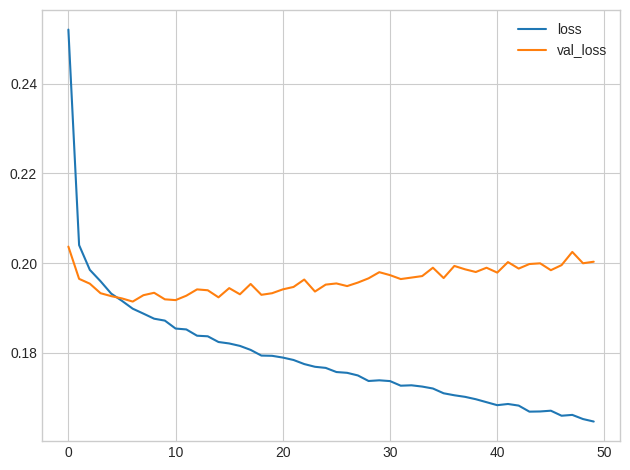

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [10]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks


# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

Epoch 1/50
49/49 [==============================] - 1s 9ms/step - loss: 0.2536 - val_loss: 0.2043
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.2061 - val_loss: 0.1979
Epoch 3/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1999 - val_loss: 0.1951
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1969 - val_loss: 0.1937
Epoch 5/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1939 - val_loss: 0.1930
Epoch 6/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1918 - val_loss: 0.1930
Epoch 7/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1907 - val_loss: 0.1921
Epoch 8/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1890 - val_loss: 0.1927
Epoch 9/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1875 - val_loss: 0.1931
Epoch 10/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1865 - val_loss: 0.1923
Epoch 11/50
49/49 [

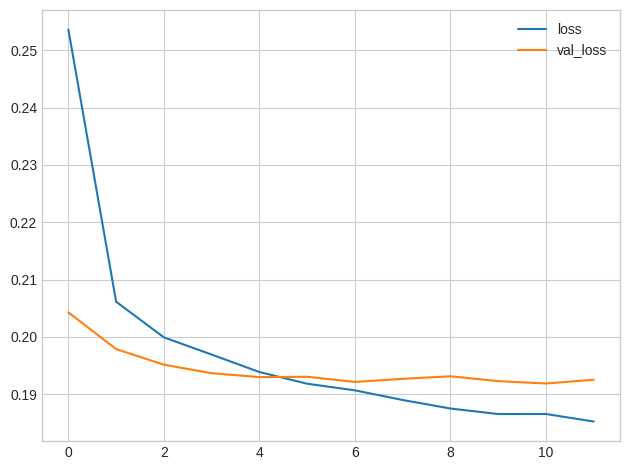

In [12]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.